In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from utils import scatter_plot

%load_ext autoreload
%autoreload 2

In [2]:
# Loading HYDRoSWOT dataset 
hydroswot = pd.read_csv('dataset/SWOT_ADCP_Dataset.csv', converters={'site_no': str}, low_memory=False)
hydroswot.shape

(223022, 75)

In [3]:
# Select desired variables and exlcude any zero/non values
candidate_columns=['site_no', 'site_tp_cd', 'q_va', 'stream_wdth_va', 'xsec_area_va', 'mean_depth_va', 'max_depth_va']

hydroswot_subset = hydroswot[(hydroswot[candidate_columns] != 0).all(axis=1)]
hydroswot_subset = hydroswot_subset.dropna(axis=0, how='any', subset=candidate_columns)
print(f"dataset size: {hydroswot_subset.shape}")

dataset size: (55231, 75)


In [4]:
# Exclude USGS sites with negative discharge observations
hydroswot_subset = hydroswot_subset[hydroswot_subset.groupby('site_no')['q_va'].transform(lambda x: (x<0).sum()) == 0]
print(hydroswot_subset.shape)

(49022, 75)


In [5]:
# Keep only sites categorized as channels or streams
hydroswot_subset = hydroswot_subset[hydroswot_subset['site_tp_cd'].isin(['ST'])]
print(hydroswot_subset.shape)

(47522, 75)


In [6]:
# Reset DataFrame index and print the statistics of the unique USGS sites 
hydroswot_subset.reset_index(drop=True, inplace=True)

print("site locations with positive discharge: ")
hydroswot_subset['site_no'].value_counts().describe()

site locations with positive discharge: 


count    5914.000000
mean        8.035509
std        10.050780
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max       159.000000
Name: count, dtype: float64

In [7]:
# Print the statistics of all variables
hydroswot_subset[candidate_columns].describe()

,q_va,stream_wdth_va,xsec_area_va,mean_depth_va,max_depth_va
count,4.752200e+04,47522.000000,47522.000000,47522.000000,47522.000000
mean,1.100066e+04,239.193869,3431.116848,6.682162,9.857616
std,5.903527e+04,397.990026,14575.380645,7.269928,10.752993
min,5.300000e-02,2.550000,1.080000,0.520000,0.680000
25%,2.391915e+02,69.230000,195.000250,2.677000,4.085000
50%,8.000850e+02,122.638000,529.430000,4.460000,6.791000
75%,3.128004e+03,244.187250,1585.674250,7.842750,11.407000
max,2.257500e+06,16361.950000,357000.000000,118.770000,205.670000


In [8]:
hydroswot_site_list = hydroswot_subset['site_no'].value_counts()
hydroswot_subset_stat = hydroswot_subset[hydroswot_subset["site_no"].isin(hydroswot_site_list.index[hydroswot_site_list>=50].to_list())]

print("site locations with minimum of 50 observations: ")
print(f'Number of observations: {hydroswot_subset_stat.shape}')
print('Number of sites:')
hydroswot_subset_stat['site_no'].value_counts().describe()

site locations with minimum of 50 observations: 
Number of observations: (2285, 75)
Number of sites:


count     26.000000
mean      87.884615
std       37.913931
min       50.000000
25%       56.250000
50%       69.500000
75%      125.250000
max      159.000000
Name: count, dtype: float64

### Evaluation of maximum depth model:

In [9]:
# Imperial unit
x = (hydroswot_subset['mean_depth_va']).to_numpy()
y = (hydroswot_subset['max_depth_va']).to_numpy()

# Convert the variable units into SI
x_si = (hydroswot_subset['mean_depth_va']*0.3048).to_numpy()
y_si = (hydroswot_subset['max_depth_va']*0.3048).to_numpy()

# Estimate the model parameters
print(f'Slope: {np.std(y) / np.std(x):.4f}')
print(f'Intercept: {np.mean(y) - (np.std(y) / np.std(x)) * np.mean(x):.4f} (Imperial) \
      {np.mean(y_si) - (np.std(y_si) / np.std(x_si)) * np.mean(x_si):.4f} (SI)')

Slope: 1.4791
Intercept: -0.0260 (Imperial)       -0.0079 (SI)


test size: (47522,), pred size: (47522,)
NSE: 0.9375, r: 0.9688, PBias: -2.95E-14, RMSE: 2.6879


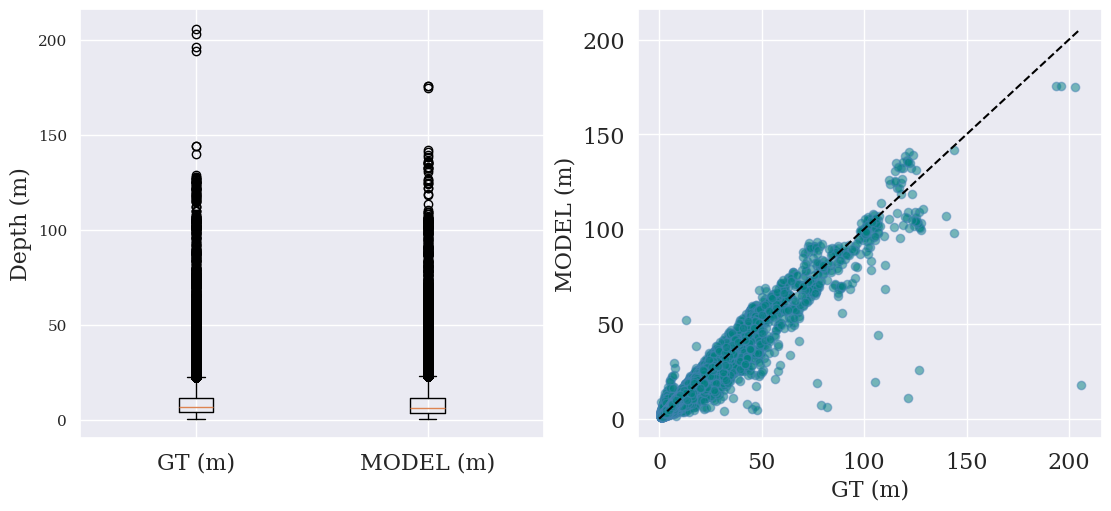

In [10]:
# Calculate max depth model outputs and plot agains GTs
y_pred = (np.std(y) / np.std(x) * x) + (np.mean(y) - (np.std(y) / np.std(x)) * np.mean(x))
scatter_plot(y, y_pred, model_name='depth-max')

### Evaluation of minimum depth model (Mean Value Theorem for Integrals)

test size: (47522,), pred size: (47522,)
NSE: 0.7579, r: 0.8942, PBias: -3.34E+00, RMSE: 1.0902


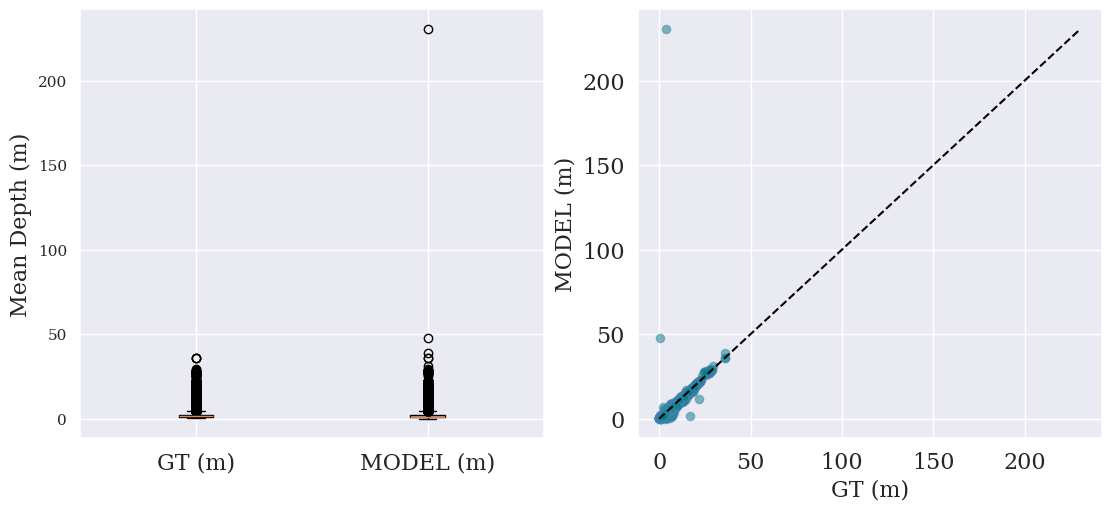

In [11]:
# Calculate mean depth model outputs and plot agains GTs
gt    = (hydroswot_subset['mean_depth_va']*0.3048).to_numpy()
model = ((hydroswot_subset['xsec_area_va'] / hydroswot_subset['stream_wdth_va'])*0.3048).to_numpy()

scatter_plot(gt, model, yax1_name='Mean Depth (m)', log_mode=False)

In [22]:
# Finding the outliers generated by the model
idx = hydroswot_subset['xsec_area_va'] / hydroswot_subset['stream_wdth_va']

hydroswot_outliers = hydroswot_subset[idx > 150]
hydroswot_outliers['site_no']

9218       13032500
43776    1220070360
Name: site_no, dtype: object

Site number `1220070360` has two measurements. In the Second measurement `stream width` has typo. It should be in the order of 300 to 400. 

In [24]:
hydroswot_subset[(hydroswot_subset['site_no'] == '1220070360')][candidate_columns]

,site_no,site_tp_cd,q_va,stream_wdth_va,xsec_area_va,mean_depth_va,max_depth_va
43775,1220070360,ST,9230.0,300.00,3690.0,12.3,16.9
43776,1220070360,ST,9350.0,4.89,3700.0,12.4,17.8


Site number `13032500` has two measurements. In the Second measurement `stream width` has typo. It should be in the order of 200 to 300. 

In [25]:
hydroswot_subset[(hydroswot_subset['site_no'] == '13032500')][candidate_columns]

,site_no,site_tp_cd,q_va,stream_wdth_va,xsec_area_va,mean_depth_va,max_depth_va
9196,13032500,ST,10617.781,332.347,1744.024,4.950000,7.100
9197,13032500,ST,13307.690,344.690,2071.249,5.520000,7.800
9198,13032500,ST,749.395,252.256,399.221,1.770000,2.477
9199,13032500,ST,3524.033,308.553,942.943,3.056016,4.551
9200,13032500,ST,10003.091,342.139,1815.069,5.305063,7.093
9201,13032500,ST,10007.576,335.696,1813.309,5.354000,7.198
9202,13032500,ST,895.121,252.548,465.172,1.841915,3.625
9203,13032500,ST,14500.627,342.652,2100.718,5.750000,8.250
9204,13032500,ST,1394.470,263.268,544.583,2.211000,3.048
9205,13032500,ST,1011.200,260.253,477.825,2.054000,2.831


In [26]:
# Keep the measurements within a 99% confidence interval (exclude the outliers)
idx = hydroswot_subset['xsec_area_va'] / hydroswot_subset['stream_wdth_va'] - hydroswot_subset['mean_depth_va']

pct = 0.005
hydroswot_subset = hydroswot_subset[(idx > idx.quantile(pct)) & (idx < idx.quantile(1-pct))]

test size: (47046,), pred size: (47046,)
NSE: 0.9936, r: 0.9974, PBias: -3.46E+00, RMSE: 0.1682


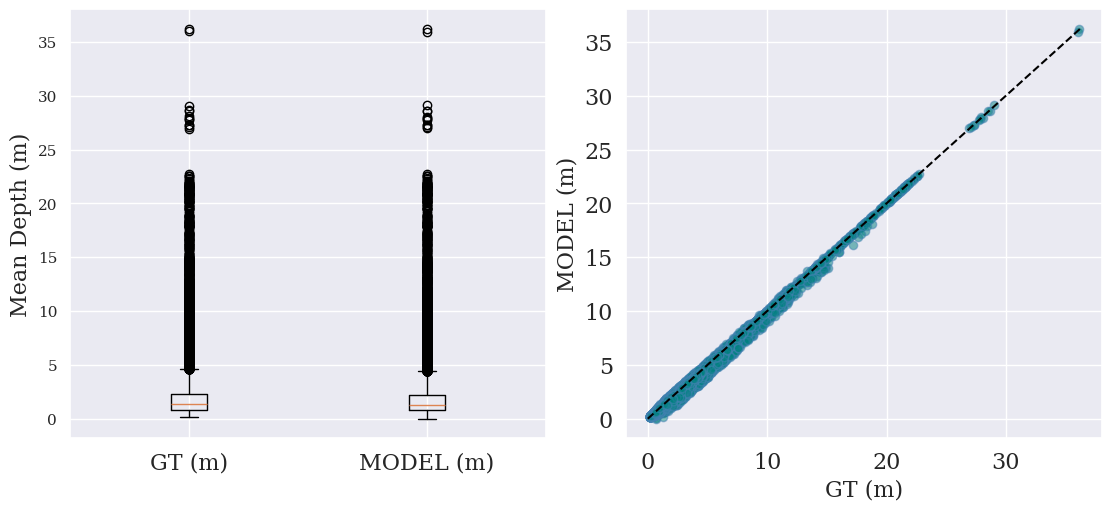

In [27]:
gt    = (hydroswot_subset['mean_depth_va']*0.3048).to_numpy()
model = ((hydroswot_subset['xsec_area_va'] / hydroswot_subset['stream_wdth_va'])*0.3048).to_numpy()

scatter_plot(gt, model, yax1_name='Mean Depth (m)', log_mode=False)